# Hyperparameter Tuning

In [153]:
import numpy as np
import pandas as pd

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from src.helper_utilities import load_data
from src.modeling_utilities import f2_scorer
from src.plotting_utilities import plot_errors


In [141]:
import warnings
warnings.filterwarnings(action='ignore', category=Warning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [142]:
random_state = 42
cv = 5
n_iter = 50

In [143]:
# load the original dataset as df
X, y = load_data(mode='modeling', format='dataframe', introduce_nans=0.01, random_state=random_state)

# the "orange" dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

# the "green" dataset
X_dev, X_val, y_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

# X_... is a pd.DataFrame
X_test[:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
690,A11,15.0,A34,A42,975.0,A61,A73,2.0,A91,A101,3.0,A122,25.0,A143,A152,2.0,A173,1.0,A191,A201
296,A14,12.0,A32,A41,4675.0,A65,A72,NaN,A92,A101,4.0,A123,20.0,A143,A151,1.0,A173,1.0,A191,A201
672,A14,60.0,A32,A40,10366.0,A61,A75,2.0,A93,A101,4.0,A122,42.0,A143,A152,1.0,A174,1.0,A192,A201


In [144]:
sv = joblib.load("models/sv.pkl")
gb = joblib.load("models/gb.pkl")
lr = joblib.load("models/lr.pkl")
pr = joblib.load("models/pr.pkl")
dt = joblib.load("models/dt.pkl")

In [145]:
hps = []

params = {
    sv: {
        'classifier__class_weight': ['balanced'],
        'classifier__C': np.logspace(-2, 2, num=5, base=10),
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto', 0.1, 1, 10],
            },
    
    gb: {
        'classifier__class_weight': ['balanced'],
        'classifier__n_estimators': [25, 50, 100, 150],
        #'classifier__objective': ['binary', f2_scorer],
        #'classifier__min_child_samples': [3, 5, 10, 20, 25]
        },

    lr: {
        'classifier__penalty': ['l1'],
        'classifier__class_weight': ['balanced'],
        'classifier__max_iter': [900],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__C': np.logspace(-2, 2, num=5, base=10),
    },

    pr: {
        'classifier__class_weight': ['balanced'],
        'classifier__penalty': ['l2'],
        'classifier__max_iter': [900],
        'poly__degree': [1,2],
        'classifier__solver': ['liblinear', 'lbfgs'],
        'classifier__C': np.logspace(-2, 2, num=5, base=10),
    },

    dt: {
        'classifier__class_weight': ['balanced'],
        'classifier__min_samples_split': [2, 3, 5],
        'classifier__min_samples_leaf': [1, 2, 3]
    },
}


for md, d in params.items():
    hp = RandomizedSearchCV(md, d, cv=cv, scoring=f2_scorer, n_iter=n_iter).fit(X_train, y_train)
    hps.append(hp)

    df = pd.DataFrame(hp.cv_results_['params'])
    df["score"] = hp.cv_results_['mean_test_score'].round(2)
    df["std"] = hp.cv_results_['std_test_score'].round(3)
    df.columns = [col[col.find("__")+2 if col.find("__")>0 else 0:] for col in df.columns]
    print(md[-1].__class__.__name__ + f" (fitting time: {hp.cv_results_['mean_fit_time'].mean().round(2)}):")
    print(df.sort_values(by=['score', 'std'], ascending=[False, True]).head(5))
    print(); print()


SVC (fitting time: 0.6):
    kernel  gamma class_weight     C  score    std
0   linear   auto     balanced  0.01   0.69  0.027
9   linear      1     balanced  0.01   0.69  0.027
18  linear     10     balanced  0.01   0.69  0.027
19  linear    0.1     balanced  0.01   0.69  0.027
24  linear  scale     balanced  0.01   0.69  0.027


LGBMClassifier (fitting time: 0.05):
   n_estimators class_weight  score    std
0            25     balanced   0.62  0.042
1            50     balanced   0.61  0.054
2           100     balanced   0.58  0.062
3           150     balanced   0.57  0.060


LogisticRegression (fitting time: 0.13):
      solver penalty  max_iter class_weight      C  score    std
7       saga      l1       900     balanced   10.0   0.66  0.054
8  liblinear      l1       900     balanced  100.0   0.66  0.054
9       saga      l1       900     balanced  100.0   0.66  0.054
6  liblinear      l1       900     balanced   10.0   0.66  0.056
4  liblinear      l1       900     balanced    

In [146]:
# View the best scores (F2)
pd.Series({hp.best_estimator_[-1].__class__.__name__ + ("2" if hasattr(hp.best_estimator_[-1], 'penalty') and hp.best_estimator_[-1].penalty == 'l2' else "")
: hp.best_score_ for hp in hps}).sort_values(ascending=False).to_frame(name="F2").round(2)

,F2
SVC,0.69
LogisticRegression2,0.69
LogisticRegression,0.66
LGBMClassifier,0.62
DecisionTreeClassifier,0.56


In [148]:
best_estimators = tuple(pd.Series({hp.best_estimator_: hp.best_score_ for hp in hps}).sort_values(ascending=False).index)

In [149]:
# save the best models
joblib.dump(best_estimators, 'models/best_estimators')


['models/best_estimators']

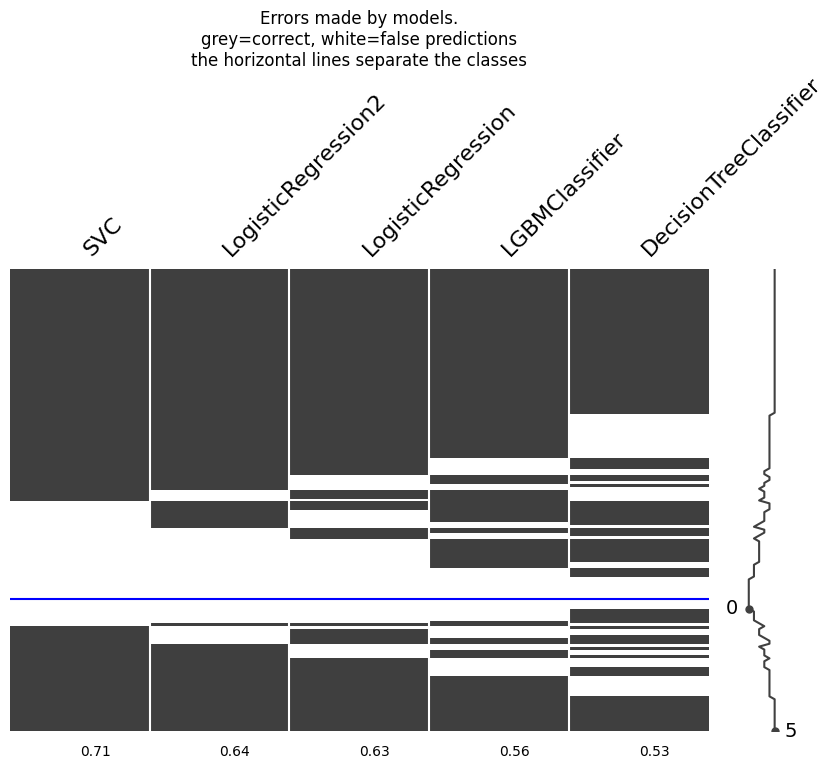

In [150]:
# Visualize the errors made
plot_errors(X_train, y_train, estimators=best_estimators, scorer=f2_scorer);